<a href="https://colab.research.google.com/github/igordantasgf/analise_dados_microambientais/blob/main/fly_eye_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import clear_output

In [3]:
col = ['TIMESTAMP', '"RECORD"', '"rtime"', '"batt_volt"', '"panel_temp"', '"CM3Up_mv_Avg"', '"CM3Up_Wm2_Avg"', '"CMP21_Avg"', '"CMP21_Wm2_Avg"', '"CelSol_01_Avg"', '"CelSol_02_Avg"', '"CelSol_03_Avg"', '"CelSol_04_Avg"', '"CelSol_05_Avg"', '"CelSol_06_Avg"', '"CelSol_07_Avg"', '"CelSol_08_Avg"', '"CelSol_09_Avg"', '"CelSol_10_Avg"', '"CelSol_11_Avg"', '"CelSol_12_Avg"', '"CelSol_13_Avg"', '"CelSol_14_Avg"', '"CelSol_15_Avg"', '"CelSol_16_Avg"', '"CelSol_17_Avg"']
labmim = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/plataforma/LBM_solar_2022.dat',sep=';', header=None,skiprows=lambda x:x in [0,1,2,3], names=col)
labmim[col] = labmim.TIMESTAMP.str.split(",", expand = True)
labmim.index = (labmim['TIMESTAMP'])
clear_output()

In [4]:
def calcular_nan():
  count = labmim.isna().any(axis=1).sum()
  print(f"Number of rows with at least one NaN value: {count}")
  print(f"Total rows in series: {len(labmim)}")
calcular_nan()

Number of rows with at least one NaN value: 0
Total rows in series: 459301


In [5]:
#@markdown ## Organização da tabela de dados
sensors=col[9:]
labmim_backup = labmim

for i in sensors:
  x=0
  unique_types = set()
  #for item in labmim_backup[i]:
  #  unique_types.add(type(item))
  #print(unique_types)
  labmim_backup[i] = [int(x) if str(x).isdigit() else 0 for x in labmim_backup[i]]

# Coluna com separação de horas para agrupamento e agregação
labmim_backup['data_hora'] = [i[0:13] for i in labmim_backup['TIMESTAMP']]

In [6]:
#@markdown ## Função para separar valores (soma, média d.m., média h.m, etc)
sensors=col[9:]

#@markdown **gerar_valores(tabela, var)**
def gerar_valores(tabela,var):
  values=[]
  if var==0: #@markdown - 0 = Soma de todos os valores da série
    for i in sensors:
      values.append(sum(labmim_backup[i]))
    final = [values[0:8],values[8:16],[values[16]]*8]
    return final

#@markdown **gerar_ranged(tabela, date1, date2)** 
#@markdown #### Dados separados em: média(acumulado(média/hora)/dia)
#@markdown - date1 = Data incial a ser analisada $($formato: "$2012-04-12$"$)$
#@markdown - date2 = Data final a ser analisada. Se não for informado, analisa até o último dia registrado.
def gerar_ranged(tabela, date1, date2=None):
  values=[]

  if date2 != None:
    range1, range2 = date1+" 00:00:00", date2+" 00:00:00"
    tabela = labmim_backup.loc[range1:range2]
  else:
    range1 = date1+" 00:00:00"
    tabela = labmim_backup.loc[range1:]

 
  tabela = tabela.groupby('data_hora').agg('mean') # média por hora

  tabela['datas'] = [i[0:10] for i in tabela.index]
  tabela = tabela.groupby('datas').agg('sum') # acumulado por dia

  tabela = tabela.agg('mean') # média do range de dias
  final = [tabela[0:8],tabela[8:16],[tabela[16]]*8]
  return final

In [76]:
#@markdown ## Formação das novas coordenadas para a interpolação
#@markdown - Matriz 6x100 replicada à esquerda e direita, resultando em uma matriz 6x300
#@markdown - Ao fim, será extraído uma matriz a partir do meio, com dimensões 6x100
pol = []
colunas_i=[round(i) for i in np.linspace(10,590,48)]
for u in [5,3,1]:
  p = []
  for v in colunas_i:
    p.append([u,v])
  pol.append(p)

In [111]:
#@markdown ## Função de interpolação
#@markdown #### **metodo**:
#@markdown - "geral" : valor acumulado para todos os sensores
#@markdown - "tempo" : valor acumulado para todos os sensores
#@markdown - - inicio: ano-mes-dia
#@markdown - - fim: ano-mes-dia. Se não for informado, calcula até a última linha

#matriz_original = gerar_valores(labmim_backup, 0)
def interpolar_dados(metodo, inicio=None, fim=None):
  if metodo == 'tempo':
    matriz_original = gerar_ranged(labmim_backup, inicio, fim) # <---   Colocar range de datas aqui
  if metodo == 'geral':
    matriz_original = gerar_valores(labmim_backup, 0)

  matriz_original = np.hstack((matriz_original,matriz_original,matriz_original,matriz_original,matriz_original,matriz_original))
  coordenadas = np.array(pol)

  # Definindo a grade da nova matriz
  x_new = np.linspace(0, 599, 600)
  y_new = np.linspace(0, 5, 6)
  print(len(x_new))
  print(len(y_new))

  # Criando uma função interpoladora
  f = interp2d(coordenadas[:, :, 1], coordenadas[:, :, 0], matriz_original, kind='cubic')

  # Aplicando a função interpoladora na nova grade
  nova_matriz_expandida = f(x_new, y_new)
  clear_output()
  return nova_matriz_expandida

nova_matriz_expandida = interpolar_dados('tempo', '2022-04-01', '2022-06-01')
nova_matriz = nova_matriz_expandida[:,275:375]  

<ipython-input-112-b657b888ed76>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('hot')


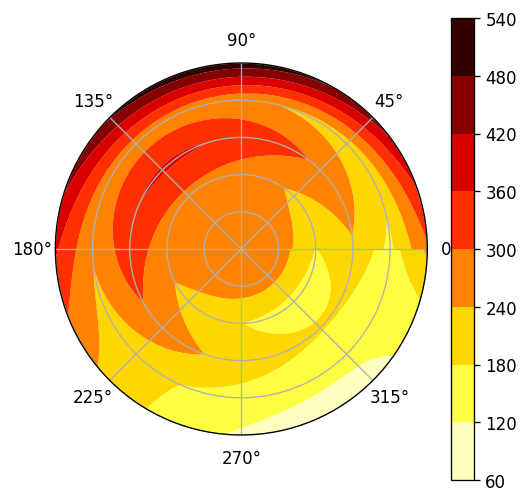

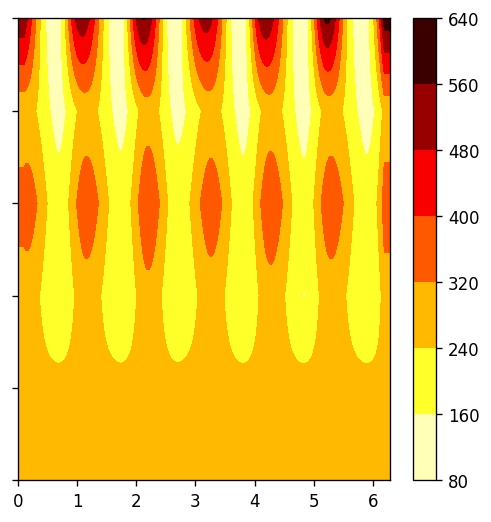

In [112]:
a = np.linspace(0,2*np.pi,100) # Sepação das partes em radianos
b = np.linspace(0,1,6) # Camadas por distancia ao centro
A, B = np.meshgrid(a, b)
c = nova_matriz

orig_map=plt.cm.get_cmap('hot')

#actual plotting
fig, ax = plt.subplots(figsize=(5,5),dpi=120,subplot_kw=dict(projection='polar'))
ax.set_yticklabels([])
ctf = ax.contourf(a, b, c, cmap=orig_map.reversed(), antialiased=True)
plt.colorbar(ctf)

fig, ax1 = plt.subplots(figsize=(5,5),dpi=120)
ax1.set_yticklabels([])
ctf = ax1.contourf(np.linspace(0,2*np.pi,600), b, nova_matriz_expandida, cmap=orig_map.reversed())
plt.colorbar(ctf)